In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Read in data
data = pd.read_csv('data/parsed_data.csv').fillna('')
data['tags'] = data['tags'].apply(ast.literal_eval)

In [3]:
# Basic statistics
num_questions = data.shape[0]
tag_counts = data.explode('tags')['tags'].value_counts()

print(f'Number of questions: {num_questions}')
print(f'Number of unique (sufficiently large) tags: {len(tag_counts[tag_counts > 9000])}')

Number of questions: 235312
Number of unique (sufficiently large) tags: 30


In [4]:
rel_tags = [
    'real-analysis',
    'calculus',
    'linear-algebra',
    'probability',
    'abstract-algebra',
    'integration',
    'sequences-and-series',
    'combinatorics',
    'general-topology',
    'matrices',
    'functional-analysis',
    'complex-analysis',
    'geometry',
    'group-theory',
    'algebra-precalculus',
    'probability-theory',
    'ordinary-differential-equations',
    'limits',
    'analysis',
    'number-theory',
    'measure-theory',
    'statistics',
    'multivariable-calculus',
    'functions',
    'derivatives',
    'differential-geometry',
    'discrete-mathematics',
    'trigonometry',
    'algebraic-geometry',
    'elementary-set-theory'
]
data['tags'] = data['tags'].apply(lambda x: [tag for tag in x if tag in rel_tags])

data[data['tags'].str.len() > 1]

,question_id,title,body,tags,title_text,title_latex,body_text,body_latex
2,11,Is it true that $0.999999999\ldots=1$?,I'm told by smart people that $$0.999999999\ld...,"[algebra-precalculus, real-analysis]",Is it true that <LATEX>?,0.999999999\ldots=1,I'm told by smart people that <LATEX> and I be...,0.999999999\ldots=1
4,22,Why is the matrix-defined Cross Product of two...,"By matrix-defined, I mean $$\left<a,b,c\right>...","[matrices, linear-algebra]",Why is the matrix-defined Cross Product of two...,,"By matrix-defined, I mean <LATEX> ...instead o...","\left<a,b,c\right>\times\left<d,e,f\right> = \..."
9,59,Calculating an Angle from $2$ points in space,"Given two points $p_1$ , $p_2$ around the orig...","[geometry, linear-algebra]",Calculating an Angle from <LATEX> points in space,2,"Given two points <LATEX> , <LATEX> around the ...","p_1 p_2 (0,0) 2D p_1 p_2 3D"
21,155,How can you prove that a function has no close...,"In the past, I've come across statements alon...","[calculus, integration, real-analysis]",How can you prove that a function has no close...,,"In the past, I've come across statements alon...",f(x) f(x) f(x) = x^x \dfrac{\sin(x)}{x}
30,255,Why does the series $\sum_{n=1}^\infty\frac1n$...,Can someone give a simple explanation as to wh...,"[sequences-and-series, calculus]",Why does the series <LATEX> not converge?,\sum_{n=1}^\infty\frac1n,Can someone give a simple explanation as to wh...,\sum_{n=1}^\infty\frac1n=\frac 1 1 + \frac 12 ...
...,...,...,...,...,...,...,...,...
235302,1385147,Longest sequence of primes with no difference ...,Let $N\ge 1$ be a natural number. The object i...,"[sequences-and-series, number-theory]",Longest sequence of primes with no difference ...,2n,Let <LATEX> be a natural number. The object is...,"N\ge 1 p_1<p_2<...<p_n p_{i+1}-p_i\leq 2N i=1,..."
235303,1385148,Under what conditions does a specified conditi...,It is common to see conditional distributions ...,"[probability-theory, measure-theory]",Under what conditions does a specified conditi...,,It is common to see conditional distributions ...,"(X \mid \mu = t) \sim \mathcal{N} (t, 1)"
235304,1385165,Finding fomulas for hyperbolic functions,I'm trying to find formulas for hyperbolic fun...,"[trigonometry, integration]",Finding fomulas for hyperbolic functions,,I'm trying to find formulas for hyperbolic fun...,\frac{\alpha}{2} \nx^2 - y^2 = 1\n \nx = \sqrt...
235307,1385227,"Number of increasing functions from $\{1,2,\do...","Let $f$ be a function from $X=\{1,2,3,...,n\}$...","[discrete-mathematics, combinatorics]",Number of increasing functions from <LATEX> to...,"\{1,2,\dots, n\}",Let <LATEX> be a function from <LATEX> to itse...,"f X=\{1,2,3,...,n\} f a\le b f(a)\le f(b) f(1)"


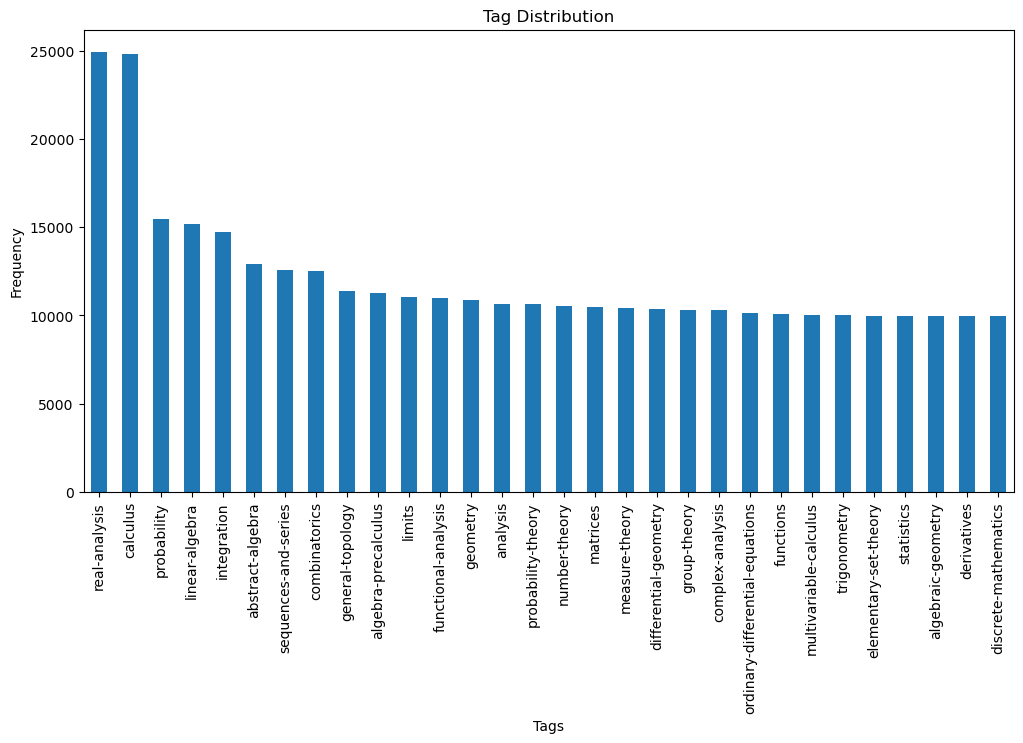

In [5]:
# Distribution of tags
plt.figure(figsize=(12,6))
tag_counts.head(30).plot(kind='bar')
plt.title('Tag Distribution')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.savefig('figs/exploratory_analysis/tag_distribution.png', bbox_inches='tight')
plt.show()

C:\Users\joetn\AppData\Local\Temp\ipykernel_21064\1840040114.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tag_num', y='question_id', data=group_by, palette='viridis')


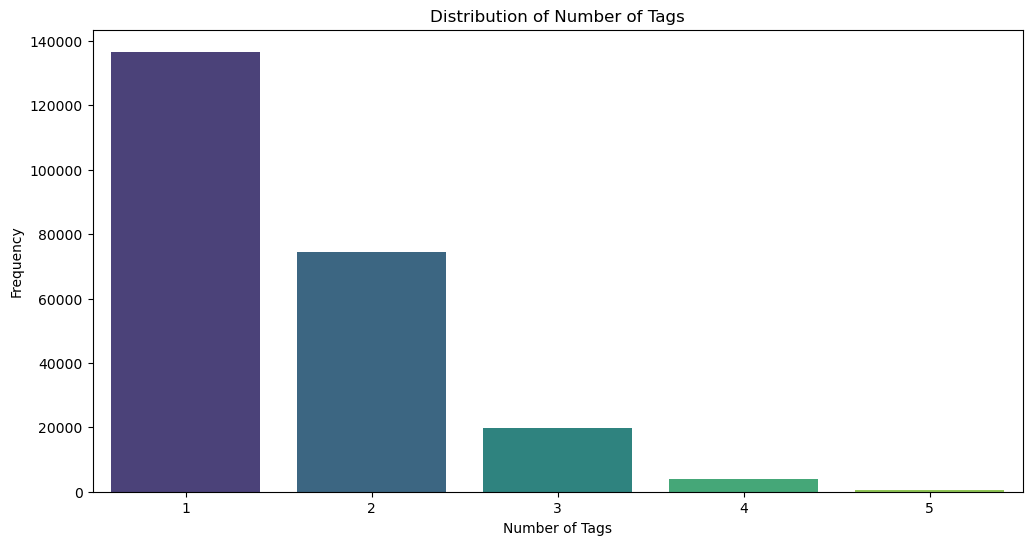

In [31]:
# Distribution of number of tags
plt.figure(figsize=(12,6))
data['tag_num'] = data['tags'].str.len()
group_by = data[data['tags'].str.len() != 0].groupby('tag_num').count()['question_id'].reset_index()
sns.barplot(x='tag_num', y='question_id', data=group_by, palette='viridis')
plt.title('Distribution of Number of Tags')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.savefig('figs/exploratory_analysis/tag_number_distribution.png', bbox_inches='tight')
plt.show()

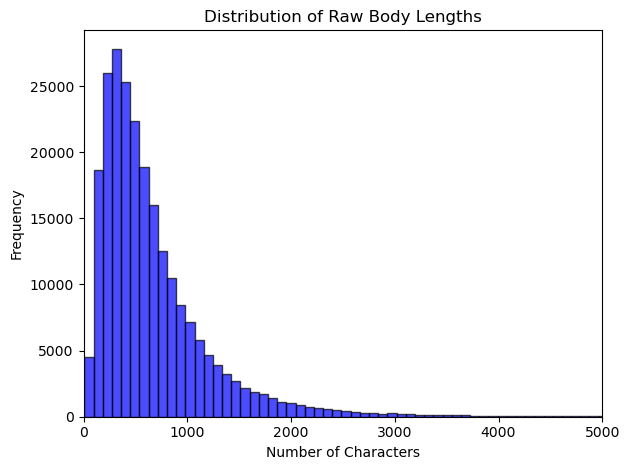

In [18]:
# Text length analysis
data['body_text_length'] = data['body_text'].apply(lambda x: len(x))
data['body_length'] = data['body'].apply(lambda x: len(x))
data['body_latex_length'] = data['body_latex'].apply(lambda x: len(x))

plt.hist(data['body_text_length'], bins=300, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Raw Body Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 5000)

plt.tight_layout()
plt.savefig('figs/exploratory_analysis/length_distribution.png', bbox_inches='tight')
plt.show()

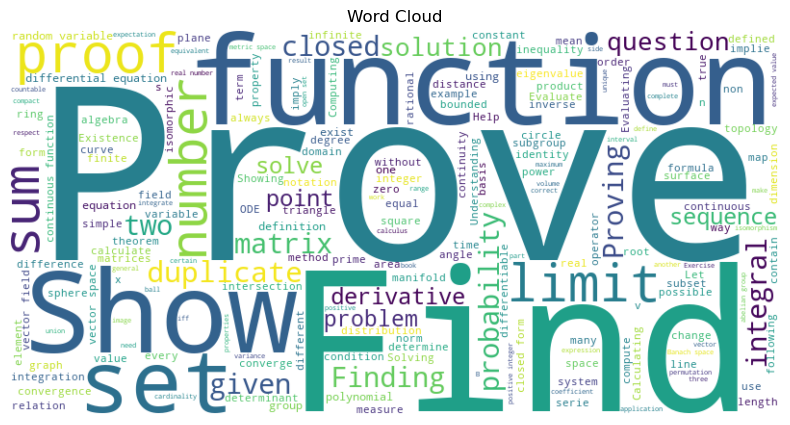

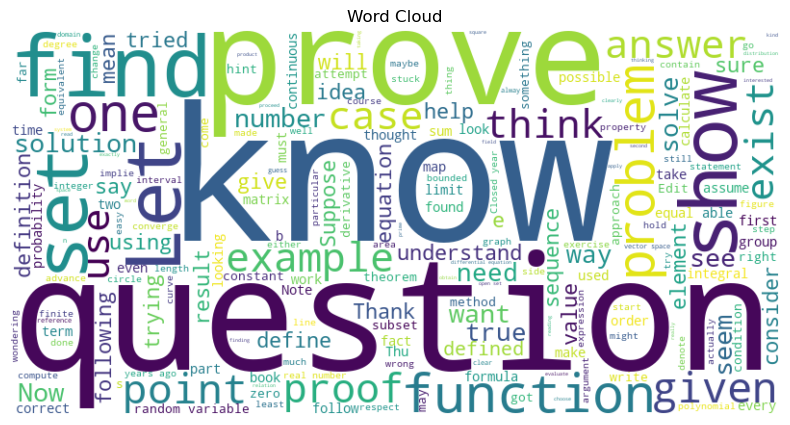

In [36]:
# Wordcloud
title_text = ' '.join(data['title_text'].str.replace('<LATEX>', ''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.savefig('figs/exploratory_analysis/title_wordcloud.png', bbox_inches='tight')
plt.show()

# Word cloud for body text
body_text = ' '.join(data['body_text'].str.replace('<LATEX>', ''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(body_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.savefig('figs/exploratory_analysis/body_wordcloud.png', bbox_inches='tight')
plt.show()

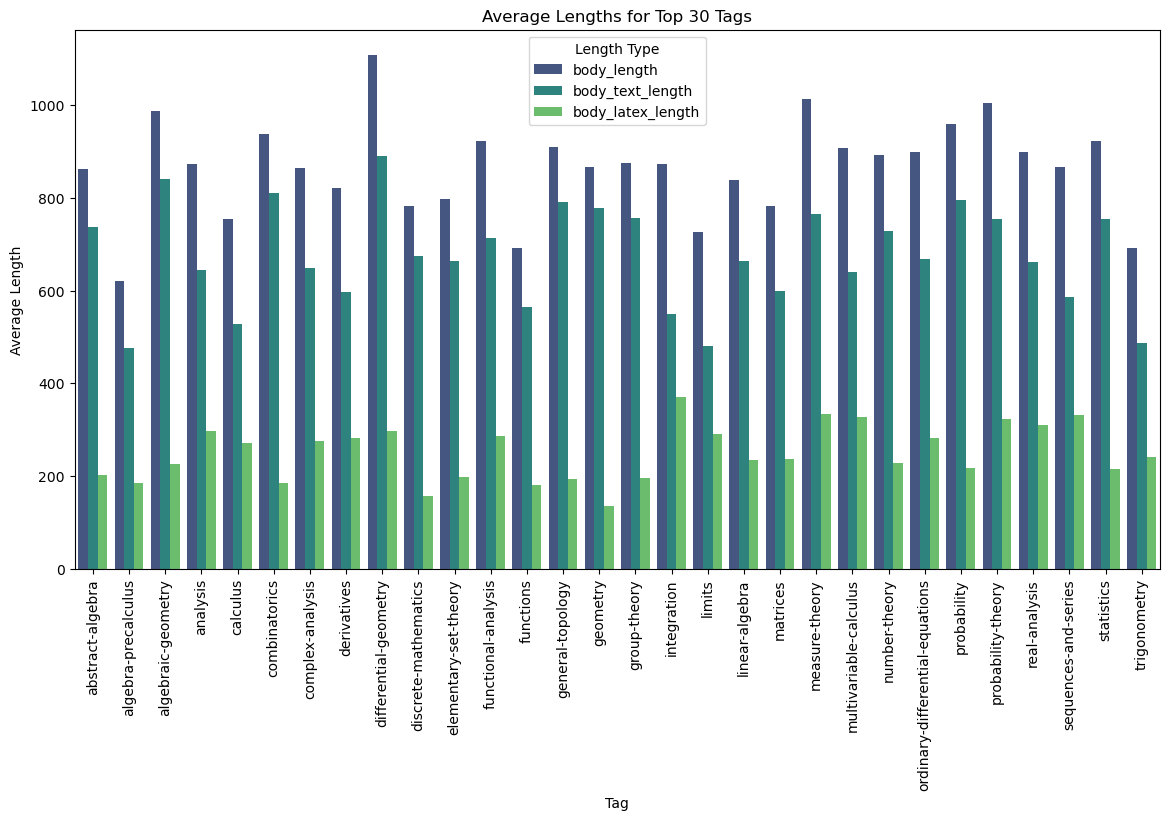

In [19]:
# Length by tag
exploded_data = data.explode('tags')
group_by = exploded_data[exploded_data.tags.isin(tag_counts.head(30).index)].groupby('tags')[[
    'body_length', 'body_text_length', 'body_latex_length']].mean().reset_index()

melted_group_by = pd.melt(group_by, id_vars='tags', value_vars=['body_length', 'body_text_length', 'body_latex_length'],
                          var_name='Length Type', value_name='Average Length')

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='tags', y='Average Length', hue='Length Type', data=melted_group_by, palette='viridis')
plt.title('Average Lengths for Top 30 Tags')
plt.xlabel('Tag')
plt.ylabel('Average Length')
plt.xticks(rotation=90)
plt.legend(title='Length Type')
plt.savefig('figs/exploratory_analysis/lengths_by_tag.png', bbox_inches='tight')
plt.show()

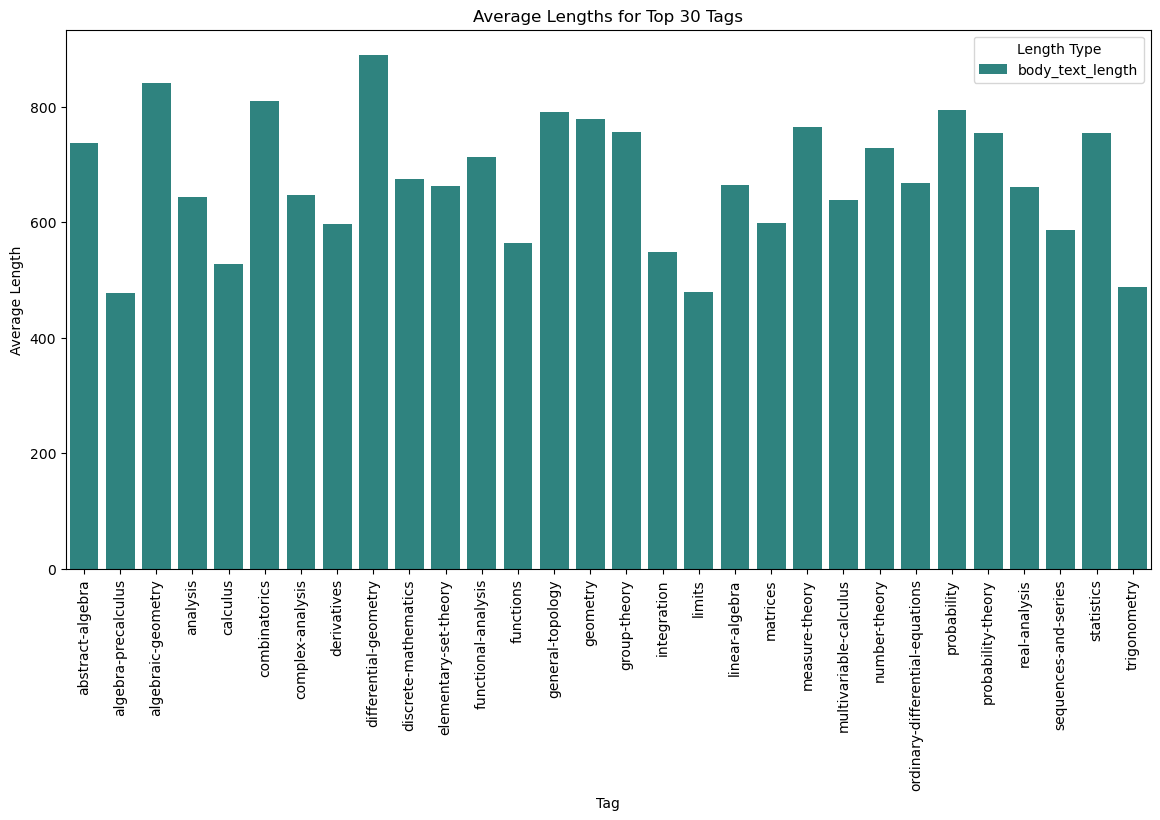

In [20]:
# Just body Length by tag
exploded_data = data.explode('tags')
group_by = exploded_data[exploded_data.tags.isin(tag_counts.head(30).index)].groupby('tags')[[
    'body_text_length']].mean().reset_index()

melted_group_by = pd.melt(group_by, id_vars='tags', value_vars=['body_text_length'],
                          var_name='Length Type', value_name='Average Length')

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(x='tags', y='Average Length', hue='Length Type', data=melted_group_by, palette='viridis')
plt.title('Average Lengths for Top 30 Tags')
plt.xlabel('Tag')
plt.ylabel('Average Length')
plt.xticks(rotation=90)
plt.legend(title='Length Type')
plt.savefig('figs/exploratory_analysis/length_by_tag.png', bbox_inches='tight')
plt.show()

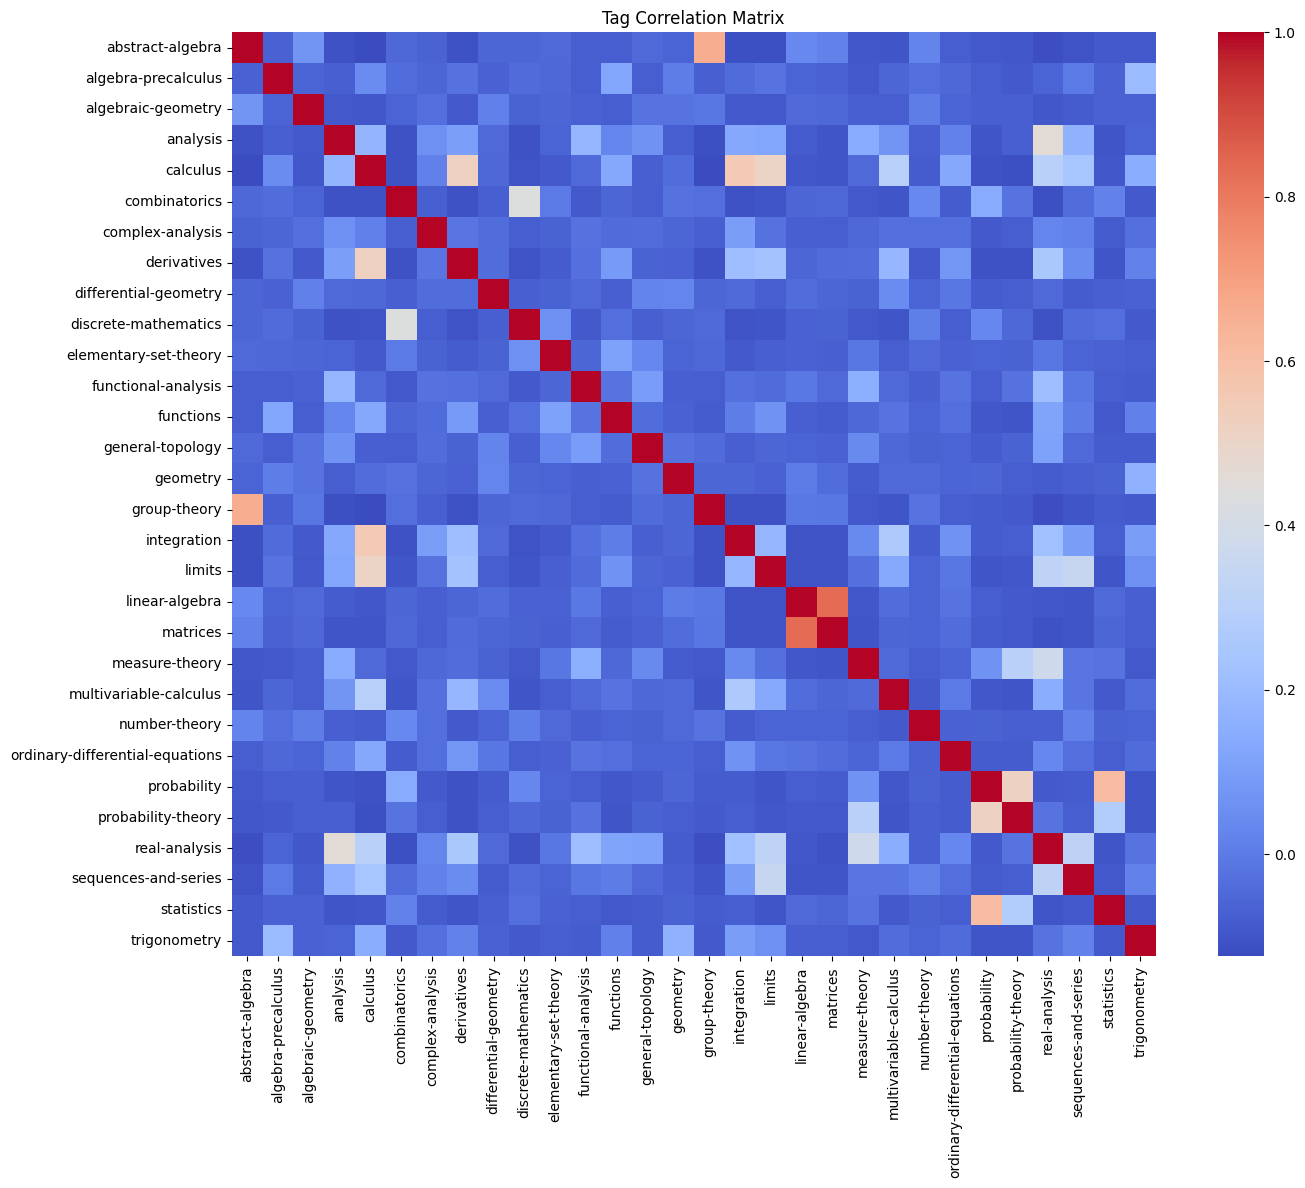

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# Filter out all not top 30 tags
data['tags_clean'] = data['tags'].apply(lambda x: [tag for tag in x if tag in tag_counts.head(30).index])

# Use MultiLabelBinarizer to create a binary matrix for tags
mlb = MultiLabelBinarizer()
tag_matrix = mlb.fit_transform(data['tags_clean'])

# Create a DataFrame from the binary matrix
tag_df = pd.DataFrame(tag_matrix, columns=mlb.classes_)

# Compute the co-occurrence matrix
co_occurrence_matrix = tag_df.T.dot(tag_df)

# Normalize the co-occurrence matrix
co_occurrence_matrix = co_occurrence_matrix / co_occurrence_matrix.max().max()

# Calculate the correlation matrix
correlation_matrix = co_occurrence_matrix.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True)
plt.title('Tag Correlation Matrix')
plt.savefig('figs/exploratory_analysis/tag_corr_mat.png', bbox_inches='tight')
plt.show()